In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

scaler = StandardScaler()
y = train.Order
df_train = scaler.fit_transform(train.drop('Order',axis=1))
df_test = scaler.transform(test)
X = df_train



先调试框架参数

In [5]:
estimator = RandomForestRegressor()
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params0 = {'n_estimators': range(1, 200 ,10)}

grid_search0 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params0, 
                        )
grid_search0.fit(X,y)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': range(1, 200, 10)},
             return_train_score=True)

In [6]:
grid_search0.best_score_, grid_search0.best_params_

(-0.1296395836208904, {'n_estimators': 121})

In [8]:
rf_clf0 = RandomForestRegressor(n_estimators=121, oob_score=True)
rf_clf0.fit(X,y).oob_score_


0.3041081772145495

下面调试树参数

In [16]:
estimator = RandomForestRegressor(n_estimators=121)
test_size=0.7
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=9)

params1 = {'max_depth':range(3,20,4),
        'min_samples_split':range(2,20,4),
        'min_samples_leaf':range(1,3)}

grid_search1 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params1, 
                        )
grid_search1.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(n_estimators=121), n_jobs=-1,
             param_grid={'max_depth': range(3, 20, 4),
                         'min_samples_leaf': range(1, 3),
                         'min_samples_split': range(2, 20, 4)},
             return_train_score=True)

In [17]:
grid_search1.best_score_, grid_search1.best_params_

(0.3690690216957543,
 {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2})

In [15]:
rf_clf1 = RandomForestRegressor(n_estimators=121, oob_score=True,max_depth=15, min_samples_leaf=1, min_samples_split=17)
rf_clf1.fit(X,y).oob_score_

0.3946091902686464

进一步调节

In [19]:
estimator = RandomForestRegressor(n_estimators=121,
                                oob_score=True,
                                max_depth=15, 
                                min_samples_leaf=1, 
                                min_samples_split=17)
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params2 = {'max_features':['sqrt', 'log2', 'auto'],
        'criterion':['mse', 'mae']}

grid_search2 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params2, 
                        )
grid_search2.fit(X,y)
grid_search2.best_score_, grid_search2.best_params_

In [3]:
rf_clf2 = RandomForestRegressor(n_estimators=161, oob_score=True,max_depth=15, min_samples_leaf=1, min_samples_split=17,
                                max_features='auto', criterion='mse')
rf_clf2.fit(X,y).oob_score_

0.3978205753070221

In [112]:
# record=pd.DataFrame(grid_result.cv_results_)

In [4]:
pred_result=rf_clf2.predict(df_test)

D:\programs\envs\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

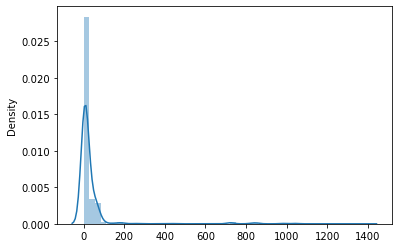

In [5]:
sns.distplot(pred_result)

In [10]:
df_test1 = pd.read_csv('test.csv')
df_test1['Order_pred'] = pred_result
df_test1.to_csv('pred.csv', index=False)

----
## 2. 逻辑回归与随机森林模型averaging融合
### 先构建逻辑回归，然后保存两者预测概率，再观察两者预测概率结果的相关性


In [40]:
train1=pd.read_csv('train_processed.csv')
test1=pd.read_csv('test_precessed.csv')
pca=PCA(n_components=1)
ncol=pca.fit_transform(train1[['SibSp','Parch']])
train1["Companion"]=ncol
pca=PCA(n_components=1)
ncol=pca.fit_transform(test1[['SibSp','Parch']])
test1["Companion"]=ncol
df_train1 = pd.get_dummies(train1, columns=["Pclass","Embarked","Sex"])
df_train1.drop('Sex_female', axis=1, inplace=True)
df_train1.drop('PassengerId', axis=1, inplace=True)
df_train1.drop('Ticket', axis=1, inplace=True)
df_train1.drop('SibSp', axis=1, inplace=True)
df_train1.drop('Parch', axis=1, inplace=True)
df_test1 = pd.get_dummies(test1, columns=["Pclass","Embarked","Sex"])
df_test1.drop('Sex_female', axis=1, inplace=True)
df_test1.drop('PassengerId', axis=1, inplace=True)
df_test1.drop('Ticket', axis=1, inplace=True)
df_test1.drop('SibSp', axis=1, inplace=True)
df_test1.drop('Parch', axis=1, inplace=True)
picked_features = ['Age', 'Companion', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_male']\


X1 = df_train1[picked_features]
y = df_train1.Survived
df_test1=df_test1[picked_features]
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
df_test1 = scaler.transform(df_test1)


from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X1, y)
result=model.predict_proba(df_test1)[:,1]
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('prob_logistic.csv')
pred_prob=rf_clf2.predict_proba(df_test)[:,1]
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':pred_prob}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('prob_rf.csv')



prob_logistic = pd.read_csv('prob_logistic.csv')
prob_rf = pd.read_csv('prob_rf.csv')
prob_logistic['logistic']=prob_logistic['Survived']
prob_logistic.drop('Survived',axis=1,inplace=True)
prob_rf['rf'] = prob_rf['Survived']
prob_rf.drop('Survived',axis=1,inplace=True)

prob_logistic['rf']=prob_rf['rf']
n_df=prob_logistic.drop(['PassengerId'], axis=1)

<AxesSubplot:>

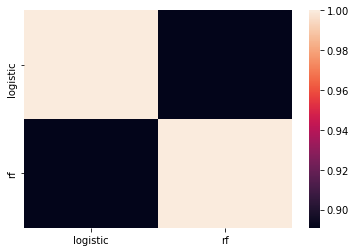

In [52]:
sns.heatmap(n_df.corr())

可以看到两种分类模型得到的结果相关性很强。还是尝试一下融合，考虑到两个模型相关性较高，另一方面分类结果得分也很相近，认为效果基本一致，所以融合取平均。

In [58]:
n_col = (n_df.rf + n_df.logistic).values/2
ensemble_result = [int(i>=0.5) for i in n_col]



In [60]:
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':ensemble_result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('ensemble_submission8.csv')